In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D 
from keras.optimizers import SGD
from keras.layers import GRU, TimeDistributed, RepeatVector, Merge, TimeDistributedDense
import h5py
import text_processor_utils as tp_utils
import cv2
import numpy as np
import theano
from keras.preprocessing import sequence
import pickle
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import image_classes as img_class
import json
from collections import Counter
import random
import lasagne
import theano.tensor as T
import matplotlib.pyplot as plt
import skimage.transform

MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))
SEQUENCE_LENGTH = 32
MAX_SENTENCE_LENGTH = SEQUENCE_LENGTH - 3 # 1 for image, 1 for start token, 1 for end token
BATCH_SIZE = 100
CNN_FEATURE_SIZE = 1000
EMBEDDING_SIZE = 256

def word_processing(dataset):
    allwords = Counter()
    for item in dataset:
        for sentence in item['sentences']:
            allwords.update(sentence['tokens'])
            
    vocab = [k for k, v in allwords.items() if v >= 5]
    vocab.insert(0, '#START#')
    vocab.append('#END#')

    word_to_index = {w: i for i, w in enumerate(vocab)}
    index_to_word = {i: w for i, w in enumerate(vocab)}
    return vocab, word_to_index, index_to_word

def import_flickr8kdataset():
    dataset = json.load(open('captions/dataset_flickr8k.json'))['images']
    #reduced length to a 300 for testing
    val_set = list(filter(lambda x: x['split'] == 'val', dataset))
    train_set = list(filter(lambda x: x['split'] == 'train', dataset))
    test_set = list(filter(lambda x: x['split'] == 'test', dataset))
    return train_set[:800]+val_set[:200]
    

def pop(model):
    '''Removes a layer instance on top of the layer stack.
    This code is thanks to @joelthchao https://github.com/fchollet/keras/issues/2371#issuecomment-211734276
    '''
    if not model.outputs:
        raise Exception('Sequential model cannot be popped: model is empty.')
    else:
        model.layers.pop()
        if not model.layers:
            model.outputs = []
            model.inbound_nodes = []
            model.outbound_nodes = []
        else:
            model.layers[-1].outbound_nodes = []
            model.outputs = [model.layers[-1].output]
        model.built = False

    return model

def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)


    return model

def floatX(arr):
    return np.asarray(arr, dtype=theano.config.floatX)

#Prep Image uses an skimage transform
def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    # Resize so smallest dim = 224, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (224, w*224/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*224/w, 224), preserve_range=True)

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, floatX(im[np.newaxis])

def chunks(l, n):
    for i in xrange(0, len(l), n):
        yield l[i:i + n]


def process_cnn_features(dataset, model, coco=False, d_set="Flicker8k_Dataset"):
    ind_process = 1
    total = len(dataset)
    for chunk in chunks(dataset, 25):
        cnn_input = floatX(np.zeros((len(chunk), 3, 224, 224)))
        for i, image in enumerate(chunk):
            print "ind_process %s total %s" %(str(ind_process),str(total))
            ind_process+=1
            if coco:
                fn = './coco/{}/{}'.format(image['filepath'], image['filename'])
            else:
                fn = d_set+'/{}'.format(image['filename'])
            try:
                im = plt.imread(fn)
                _, cnn_input[i] = prep_image(im)
            except IOError:
                continue
        features = model.predict(cnn_input)
        print "Processing Features For Chunk"
        for i, image in enumerate(chunk):
            image['cnn features'] = features[i]

def get_data_batch(dataset, size, split='train'):
    items = []
    
    while len(items) < size:
        item = random.choice(dataset)
        if item['split'] != split:
            continue
        sentence = random.choice(item['sentences'])['tokens']
        if len(sentence) > MAX_SENTENCE_LENGTH:
            continue
        items.append((item['cnn features'], sentence, item['filename']))
    
    return items

def calc_cross_ent(net_output, mask, targets):
    # Helper function to calculate the cross entropy error
    preds = T.reshape(net_output, (-1, len(vocab)))
    targets = T.flatten(targets)
    cost = T.nnet.categorical_crossentropy(preds, targets)[T.flatten(mask).nonzero()]
    return cost


# Convert a list of tuples into arrays that can be fed into the network
def prep_batch_for_network(batch,word_to_index):
    x_cnn = floatX(np.zeros((len(batch), 1000)))
    x_sentence = np.zeros((len(batch), SEQUENCE_LENGTH - 1), dtype='int32')
    y_sentence = np.zeros((len(batch), SEQUENCE_LENGTH), dtype='int32')
    mask = np.zeros((len(batch), SEQUENCE_LENGTH), dtype='bool')

    for j, (cnn_features, sentence, _) in enumerate(batch):
        x_cnn[j] = cnn_features
        i = 0
        for word in ['#START#'] + sentence + ['#END#']:
            if word in word_to_index:
                mask[j, i] = True
                y_sentence[j, i] = word_to_index[word]
                x_sentence[j, i] = word_to_index[word]
                i += 1
        #mask[j, 0] = False
                
    return x_cnn, x_sentence, y_sentence, mask

def predict(x_cnn):
    x_sentence = np.zeros((BATCH_SIZE, SEQUENCE_LENGTH - 1), dtype='int32')
    words = []
    i = 0
    while True:
        i += 1
        p0 = f(x_cnn, x_sentence)
        pa = p0.argmax(-1)
        tok = pa[0][i]
        word = index_to_word[tok]
        if word == '#END#' or i >= SEQUENCE_LENGTH - 1:
            return ' '.join(words)
        else:
            x_sentence[0][i] = tok
            if word != '#START#':
                words.append(word)

In [3]:
%matplotlib inline

In [6]:
model = VGG_16('weights/vgg16_weights.h5')
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')
dataset = import_flickr8kdataset()
process_cnn_features(dataset, model, False, "Flicker8k_Dataset")

ind_process 1 total 1000
ind_process 2 total 1000
ind_process 3 total 1000
ind_process 4 total 1000
ind_process 5 total 1000
ind_process 6 total 1000
ind_process 7 total 1000
ind_process 8 total 1000
ind_process 9 total 1000
ind_process 10 total 1000
ind_process 11 total 1000
ind_process 12 total 1000
ind_process 13 total 1000
ind_process 14 total 1000
ind_process 15 total 1000
ind_process 16 total 1000
ind_process 17 total 1000
ind_process 18 total 1000
ind_process 19 total 1000
ind_process 20 total 1000
ind_process 21 total 1000
ind_process 22 total 1000
ind_process 23 total 1000
ind_process 24 total 1000
ind_process 25 total 1000
Processing Features For Chunk
ind_process 26 total 1000
ind_process 27 total 1000
ind_process 28 total 1000
ind_process 29 total 1000
ind_process 30 total 1000
ind_process 31 total 1000
ind_process 32 total 1000
ind_process 33 total 1000
ind_process 34 total 1000
ind_process 35 total 1000
ind_process 36 total 1000
ind_process 37 total 1000
ind_process 38 to

In [7]:
pickle.dump(dataset, open('flickr8k_800_200_with_cnn_features.pkl','w'), protocol=pickle.HIGHEST_PROTOCOL)
vocab,word_to_index, index_to_word = word_processing(dataset)


In [8]:
# sentence embedding maps integer sequence with dim (BATCH_SIZE, SEQUENCE_LENGTH - 1) to 
# (BATCH_SIZE, SEQUENCE_LENGTH-1, EMBEDDING_SIZE)
l_input_sentence = lasagne.layers.InputLayer((BATCH_SIZE, SEQUENCE_LENGTH - 1))
l_sentence_embedding = lasagne.layers.EmbeddingLayer(l_input_sentence,
                                                     input_size=len(vocab),
                                                     output_size=EMBEDDING_SIZE,
                                                    )

# cnn embedding changes the dimensionality of the representation from 1000 to EMBEDDING_SIZE, 
# and reshapes to add the time dimension - final dim (BATCH_SIZE, 1, EMBEDDING_SIZE)
l_input_cnn = lasagne.layers.InputLayer((BATCH_SIZE, CNN_FEATURE_SIZE))
l_cnn_embedding = lasagne.layers.DenseLayer(l_input_cnn, num_units=EMBEDDING_SIZE,
                                            nonlinearity=lasagne.nonlinearities.identity)

l_cnn_embedding = lasagne.layers.ReshapeLayer(l_cnn_embedding, ([0], 1, [1]))

# the two are concatenated to form the RNN input with dim (BATCH_SIZE, SEQUENCE_LENGTH, EMBEDDING_SIZE)
l_rnn_input = lasagne.layers.ConcatLayer([l_cnn_embedding, l_sentence_embedding])

l_dropout_input = lasagne.layers.DropoutLayer(l_rnn_input, p=0.5)
l_lstm = lasagne.layers.LSTMLayer(l_dropout_input,
                                  num_units=EMBEDDING_SIZE,
                                  unroll_scan=True,
                                  grad_clipping=5.)
l_dropout_output = lasagne.layers.DropoutLayer(l_lstm, p=0.5)

# the RNN output is reshaped to combine the batch and time dimensions
# dim (BATCH_SIZE * SEQUENCE_LENGTH, EMBEDDING_SIZE)
l_shp = lasagne.layers.ReshapeLayer(l_dropout_output, (-1, EMBEDDING_SIZE))

# decoder is a fully connected layer with one output unit for each word in the vocabulary
l_decoder = lasagne.layers.DenseLayer(l_shp, num_units=len(vocab), nonlinearity=lasagne.nonlinearities.softmax)

# finally, the separation between batch and time dimension is restored
l_out = lasagne.layers.ReshapeLayer(l_decoder, (BATCH_SIZE, SEQUENCE_LENGTH, len(vocab)))





# cnn feature vector
x_cnn_sym = T.matrix()

# sentence encoded as sequence of integer word tokens
x_sentence_sym = T.imatrix()

# mask defines which elements of the sequence should be predicted
mask_sym = T.imatrix()

# ground truth for the RNN output
y_sentence_sym = T.imatrix()



output = lasagne.layers.get_output(l_out, {
            l_input_sentence: x_sentence_sym,
            l_input_cnn: x_cnn_sym
            })


In [11]:
loss = T.mean(calc_cross_ent(output, mask_sym, y_sentence_sym))

MAX_GRAD_NORM = 15

all_params = lasagne.layers.get_all_params(l_out, trainable=True)

all_grads = T.grad(loss, all_params)
all_grads = [T.clip(g, -5, 5) for g in all_grads]
all_grads, norm = lasagne.updates.total_norm_constraint(
    all_grads, MAX_GRAD_NORM, return_norm=True)

updates = lasagne.updates.adam(all_grads, all_params, learning_rate=0.001)

f_train = theano.function([x_cnn_sym, x_sentence_sym, mask_sym, y_sentence_sym],
                          [loss, norm],
                          updates=updates
                         )

f_val = theano.function([x_cnn_sym, x_sentence_sym, mask_sym, y_sentence_sym], loss)




In [12]:
for iteration in range(2000):
    print iteration
    x_cnn, x_sentence, y_sentence, mask = prep_batch_for_network(get_data_batch(dataset, BATCH_SIZE),word_to_index)
    loss_train, norm = f_train(x_cnn, x_sentence, mask, y_sentence)
    if not iteration % 250:
        print('Iteration {}, loss_train: {}, norm: {}'.format(iteration, loss_train, norm))
        try:
            batch = get_data_batch(dataset, BATCH_SIZE, split='val')
            x_cnn, x_sentence, y_sentence, mask = prep_batch_for_network(batch,word_to_index)
            loss_val = f_val(x_cnn, x_sentence, mask, y_sentence)
            print('Val loss: {}'.format(loss_val))
        except IndexError:
            continue


0
Iteration 0, loss_train: 6.822681427, norm: 0.216443121433
Val loss: 6.81957435608
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
Iteration 250, loss_tra

In [37]:
param_values = lasagne.layers.get_all_param_values(l_out)
d = {'param values': param_values,
     'vocab': vocab,
     'word_to_index': word_to_index,
     'index_to_word': index_to_word,
    }
pickle.dump(d, open('flickr8k_lstm_1000_trained.pkl','w'), protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
f = theano.function([x_cnn_sym, x_sentence_sym], output)

In [39]:
lasagne.layers.set_all_param_values(l_out, d['param values'])

[[  1.88433798e-04   9.52103801e-06   1.33448730e-05   2.37278937e-06
    1.05767729e-04   4.83239546e-06   3.57007120e-05   1.00476267e-04
    2.34588479e-05   1.25740407e-04   6.02085947e-06   3.86977663e-05
    4.84513157e-06   1.59565425e-05   3.92847542e-05   3.07875634e-05
    2.39839865e-05   4.43906538e-05   4.23320125e-05   1.53133296e-05
    5.29666386e-06   7.49859873e-06   3.76541720e-05   1.55464404e-05
    8.13294082e-06   4.30457840e-05   4.47108096e-06   3.97999102e-05
    5.54078360e-05   3.15536204e-06   6.52759554e-05   1.43437310e-05
    1.05154068e-05   1.48993407e-04   8.65032373e-04   5.84661611e-05
    7.24921920e-05   3.11152035e-05   3.54762706e-05   3.14716977e-04
    1.90252213e-05   2.37477598e-05   1.05256462e-04   2.29508569e-05
    1.87577552e-05   3.30790936e-05   6.66601918e-05   2.60307224e-05
    2.24158881e-04   9.26531138e-05   6.31832081e-05   4.91140490e-05
    1.65102276e-04   3.30985495e-04   5.85025809e-05   6.88245054e-05
    1.30375862e-04  

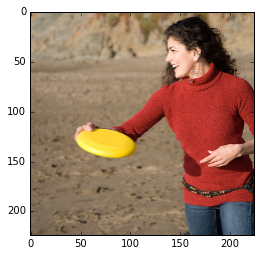

In [40]:
image = plt.imread('img/test2.jpeg')
rawim, cnn_im = prep_image(image)
plt.imshow(rawim)
x_cnn = model.predict(cnn_im)
print x_cnn

In [42]:
param_values = lasagne.layers.get_all_param_values(l_out)

In [43]:
d = pickle.load(open('flickr8k_lstm_1000_trained.pkl'))
vocab = d['vocab']
word_to_index = d['word_to_index']
index_to_word = d['index_to_word']


In [50]:
BATCH_SIZE=1
l_input_sentence = lasagne.layers.InputLayer((BATCH_SIZE, SEQUENCE_LENGTH - 1))
l_sentence_embedding = lasagne.layers.EmbeddingLayer(l_input_sentence,
                                                     input_size=len(vocab),
                                                     output_size=EMBEDDING_SIZE,
                                                    )

l_input_cnn = lasagne.layers.InputLayer((BATCH_SIZE, CNN_FEATURE_SIZE))
l_cnn_embedding = lasagne.layers.DenseLayer(l_input_cnn, num_units=EMBEDDING_SIZE,
                                            nonlinearity=lasagne.nonlinearities.identity)

l_cnn_embedding = lasagne.layers.ReshapeLayer(l_cnn_embedding, ([0], 1, [1]))

l_rnn_input = lasagne.layers.ConcatLayer([l_cnn_embedding, l_sentence_embedding])
l_dropout_input = lasagne.layers.DropoutLayer(l_rnn_input, p=0.5)
l_lstm = lasagne.layers.LSTMLayer(l_dropout_input,
                                  num_units=EMBEDDING_SIZE,
                                  unroll_scan=True,
                                  grad_clipping=5.)
l_dropout_output = lasagne.layers.DropoutLayer(l_lstm, p=0.5)
l_shp = lasagne.layers.ReshapeLayer(l_dropout_output, (-1, EMBEDDING_SIZE))
l_decoder = lasagne.layers.DenseLayer(l_shp, num_units=len(vocab), nonlinearity=lasagne.nonlinearities.softmax)

l_out = lasagne.layers.ReshapeLayer(l_decoder, (BATCH_SIZE, SEQUENCE_LENGTH, len(vocab)))

lasagne.layers.set_all_param_values(l_out, param_values)

In [51]:
x_cnn_sym = T.matrix()
x_sentence_sym = T.imatrix()

output = lasagne.layers.get_output(l_out, {
                l_input_sentence: x_sentence_sym,
                l_input_cnn: x_cnn_sym
                })

f = theano.function([x_cnn_sym, x_sentence_sym], output)

/Users/danielsampetethiyagu/anaconda/lib/python2.7/site-packages/theano/tensor/basic.py:4682: UserWarning: Warning, Cannot compute test value: input 0 (Softmax.0) of Op Reshape{3}(Softmax.0, TensorConstant{[  1  32 919]}) missing default value
  rval = op(x, newshape)


In [52]:
x_cnn.shape

(1, 1000)

In [53]:
for _ in range(1):
    print(predict((x_cnn)))

a woman in a black and white dog is running through the water
